use gpu for training


/root/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


step:0, g_loss:-0.1429923176765442, d_loss:9.978882789611816, gp:0.9978771805763245, real_loss:-0.14347906410694122, fake_loss:0.14358985424041748
step:50, g_loss:1.4869080781936646, d_loss:-0.15942835807800293, gp:0.07709263265132904, real_loss:0.4431123733520508, fake_loss:-1.3734670877456665
step:100, g_loss:1.5839247703552246, d_loss:-1.1841378211975098, gp:0.015619685873389244, real_loss:0.20179492235183716, fake_loss:-1.5421295166015625
step:150, g_loss:0.2439100593328476, d_loss:-1.8224141597747803, gp:0.01663615182042122, real_loss:-1.7490788698196411, fake_loss:-0.23969677090644836
step:200, g_loss:-0.5278515815734863, d_loss:-0.9977446794509888, gp:0.003136745188385248, real_loss:-1.697390079498291, fake_loss:0.6682780385017395
step:250, g_loss:0.3618627190589905, d_loss:0.3741416335105896, gp:0.0029156282544136047, real_loss:0.6764937043190002, fake_loss:-0.3315083384513855
step:300, g_loss:1.5766494274139404, d_loss:-0.22430852055549622, gp:0.0016822300385683775, real_loss:

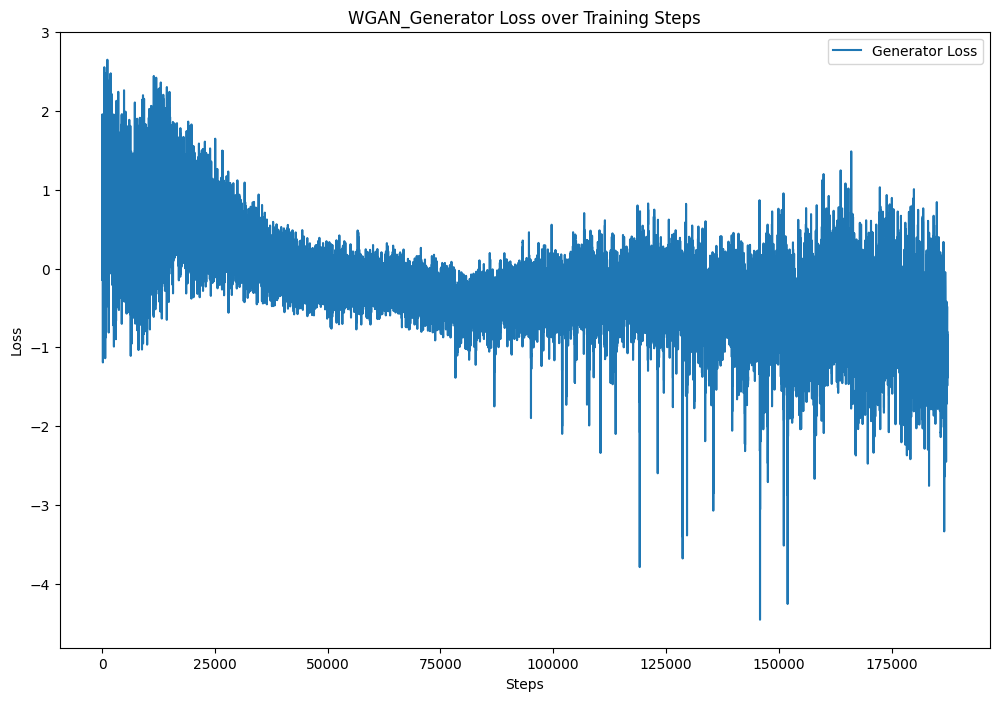

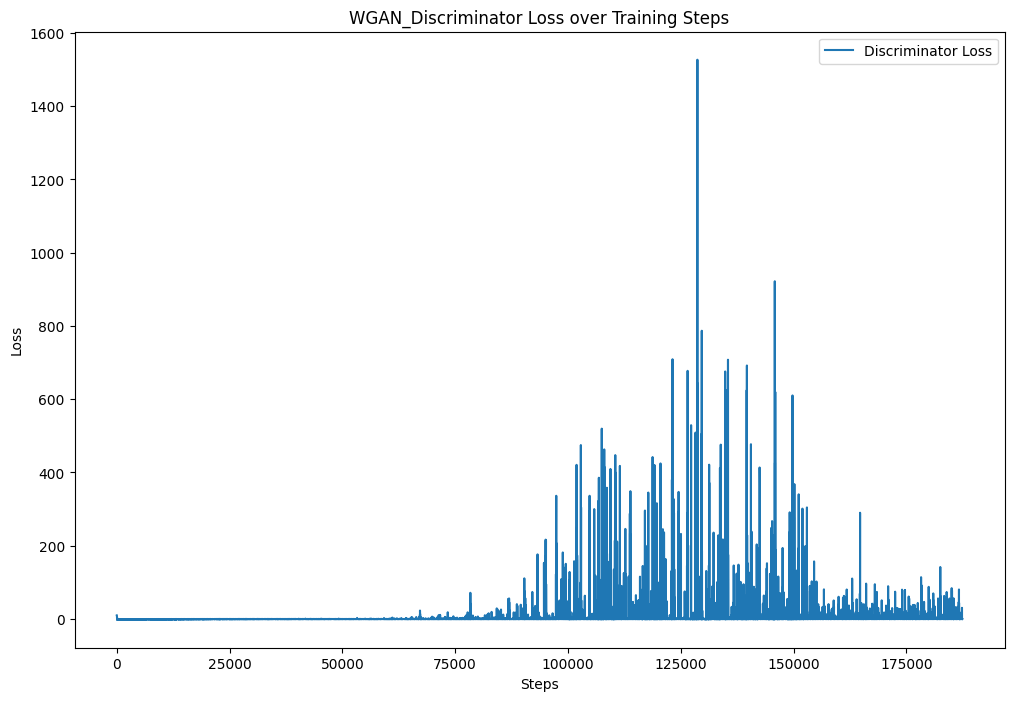

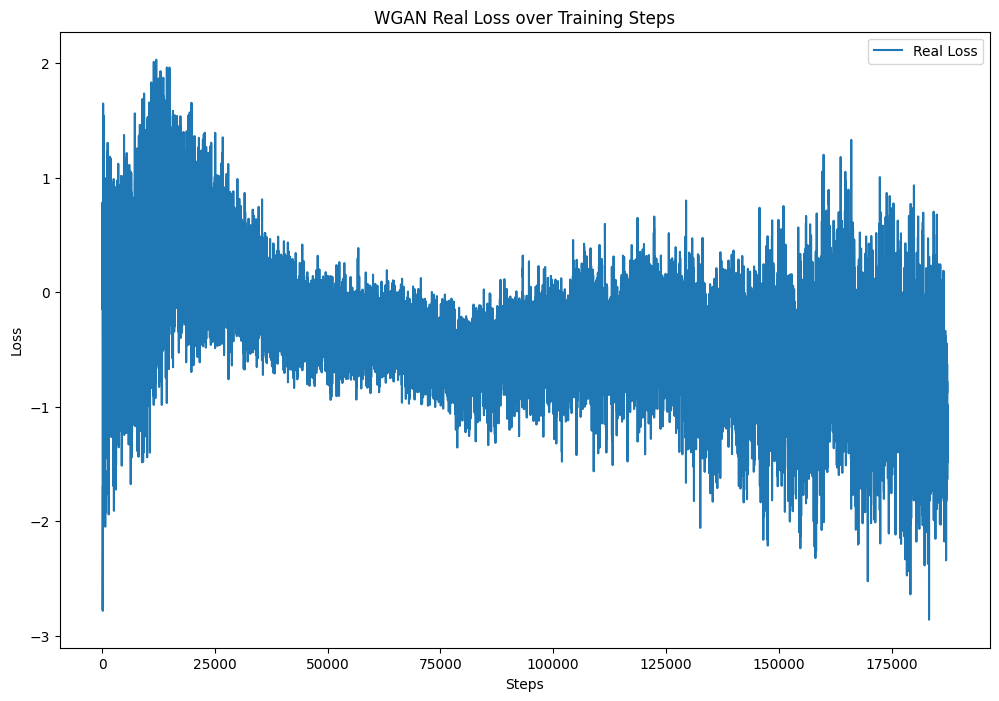

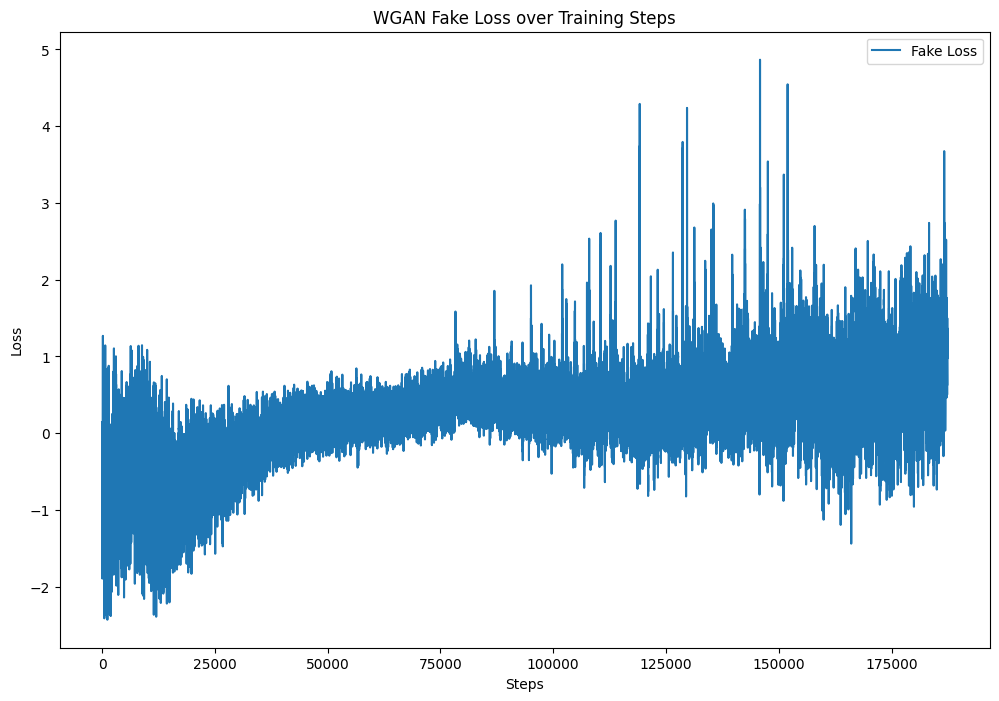

In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

image_size = [1, 28, 28]
latent_dim = 96
batch_size = 64
use_gpu = torch.cuda.is_available()

class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.GELU(),

            nn.Linear(128, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.GELU(),
            nn.Linear(256, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.GELU(),
            nn.Linear(512, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.GELU(),
            nn.Linear(1024, np.prod(image_size, dtype=np.int32)),
            nn.Sigmoid(),
        )

    def forward(self, z):
        output = self.model(z)
        image = output.reshape(z.shape[0], *image_size)
        return image


class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(np.prod(image_size, dtype=np.int32), 512),
            torch.nn.GELU(),
            nn.Linear(512, 256),
            torch.nn.GELU(),
            nn.Linear(256, 128),
            torch.nn.GELU(),
            nn.Linear(128, 64),
            torch.nn.GELU(),
            nn.Linear(64, 32),
            torch.nn.GELU(),
            nn.Linear(32, 1),
        )

    def forward(self, image):
        return self.model(image.reshape(image.shape[0], -1))

# Training
dataset = torchvision.datasets.MNIST("mnist_data", train=True, download=True,
                                     transform=torchvision.transforms.Compose(
                                         [
                                             torchvision.transforms.Resize(28),
                                             torchvision.transforms.ToTensor(),
                                         ]
                                     )
                                     )

subset_size = len(dataset)
subset, _ = torch.utils.data.random_split(dataset, [subset_size, len(dataset) - subset_size])

dataloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=True, drop_last=True)

generator = Generator()
discriminator = Discriminator()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.9))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.9))

if use_gpu:
    print("use gpu for training")
    generator = generator.cuda()
    discriminator = discriminator.cuda()

def gradient_penalty(discriminator, real_images, fake_images):
    batch_size = real_images.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1).cuda()
    epsilon = epsilon.expand_as(real_images)

    interpolated = epsilon * real_images + (1 - epsilon) * fake_images
    interpolated = interpolated.cuda()

    interpolated_output = discriminator(interpolated)

    gradients = torch.autograd.grad(outputs=interpolated_output, inputs=interpolated,
                                    grad_outputs=torch.ones(interpolated_output.size()).cuda(),
                                    create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    return ((gradients_norm - 1) ** 2).mean()

num_epoch = 200
g_losses = []
d_losses = []
real_losses = []
fake_losses = []

for epoch in range(num_epoch):
    for i, mini_batch in enumerate(dataloader):
        gt_images, _ = mini_batch

        z = torch.randn(batch_size, latent_dim)

        if use_gpu:
            gt_images = gt_images.cuda()
            z = z.cuda()

        pred_images = generator(z)

        # Discriminator training
        d_optimizer.zero_grad()

        real_loss = -torch.mean(discriminator(gt_images))
        fake_loss = torch.mean(discriminator(pred_images.detach()))
        gp = gradient_penalty(discriminator, gt_images, pred_images)

        d_loss = real_loss + fake_loss + 10 * gp
        d_loss.backward(retain_graph=True)  # Retain the graph for the generator's backward pass
        d_optimizer.step()

        # Generator training
        g_optimizer.zero_grad()

        g_loss = -torch.mean(discriminator(pred_images))
        g_loss.backward()
        g_optimizer.step()

        if i % 50 == 0:
            print(f"step:{len(dataloader)*epoch+i}, g_loss:{g_loss.item()}, d_loss:{d_loss.item()}, gp:{gp.item()}, real_loss:{real_loss.item()}, fake_loss:{fake_loss.item()}")

        # Record losses
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
        real_losses.append(real_loss.item())
        fake_losses.append(fake_loss.item())

# Plotting the losses
steps = np.arange(len(g_losses))

plt.figure(figsize=(12, 8))
plt.plot(steps, g_losses, label='Generator Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('WGAN_Generator Loss over Training Steps')
plt.savefig('WGAN_generator_loss.png')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(steps, d_losses, label='Discriminator Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('WGAN_Discriminator Loss over Training Steps')
plt.savefig('WGAN_discriminator_loss.png')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(steps, real_losses, label='Real Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('WGAN Real Loss over Training Steps')
plt.savefig('WGAN_real_loss.png')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(steps, fake_losses, label='Fake Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('WGAN Fake Loss over Training Steps')
plt.savefig('WGAN_Fake_loss.png')
plt.show()